# DTW for mapping labels

In [31]:
import numpy as np
import pandas as pd
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

## Load labeled reference

In [46]:
# ----------------------------
# Reference sequence loading
# ----------------------------

segment_labels = ["Left Foot Lift","Pause","Right Step"]

def _nearest_idx(times: np.ndarray, t: float) -> int:
    # robust nearest by absolute difference
    return int(np.argmin(np.abs(times - t)))


def load_ref_sequences(reference_file: str) -> tuple[list[np.ndarray], list[str]]:
    """Load timeseries windows + labels from a Label Studio export JSON.

    Expected shape (simplified):
        data[0]['data']['ts']['acc']      -> list/array of values
        data[0]['data']['ts']['acc_time'] -> list/array of times (same length)
        data[0]['annotations'][0]['result'] -> regions with 'value': {'start', 'end', 'timeserieslabels': [label]}
    """
    with open(reference_file, "r") as f:
        ref_data = json.load(f)

    ref_sequence_filter_list = segment_labels

    sequences: list[np.ndarray] = []
    labels: list[str] = []
    times: list[np.ndarray] = []
    for i in range(len(ref_data)):

        acc = np.asarray(ref_data[i]["data"]["ts"]["acc"], dtype=float)
        acc_time = np.asarray(ref_data[i]["data"]["ts"]["acc_time"], dtype=float)

        annotations = ref_data[i]["annotations"][0]["result"]
        for a in annotations:
            v = a["value"]
            t0 = float(v["start"])  # seconds
            t1 = float(v["end"])    # seconds
            label = str(v["timeserieslabels"][0])
            i0 = _nearest_idx(acc_time, t0)
            i1 = _nearest_idx(acc_time, t1)
            if i1 < i0:
                i0, i1 = i1, i0
            # include endpoint
            seq = acc[i0 : i1 + 1].astype(float, copy=True)
            time_data = acc_time[i0 : i1 + 1].astype(float, copy=True)
            if seq.size >= 2:
                if label in ref_sequence_filter_list or (len(ref_sequence_filter_list) == 0):
                    sequences.append(seq)
                    labels.append(label)
                    times.append(time_data)
    if not sequences:
        raise ValueError("No reference sequences parsed from JSON; check your export format.")
    return sequences, labels, times


In [47]:
reference_file = 'label_studio_export/palin_parts.json'
sequences, labels, times = load_ref_sequences(reference_file)

In [48]:
# concatenate our labelled sequences together
total_length = np.sum([len(t) for t in times])
times_array = np.concat(times,axis=0).reshape(total_length,)
acc_array = np.concat(sequences,axis=0).reshape(total_length,)
phase_array = np.concat([[l]*len(s) for l,s in zip(labels,sequences)],axis=0).reshape(total_length,)

df = pd.DataFrame({'time':times_array,'acc':acc_array,'phase':phase_array})
df = df.drop_duplicates(subset=['time'])
df

,time,acc,phase
0,0.30,0.564761,Left Foot Lift
1,0.31,0.751909,Left Foot Lift
2,0.32,0.992752,Left Foot Lift
3,0.33,1.272258,Left Foot Lift
4,0.34,1.555093,Left Foot Lift
...,...,...,...
292,3.20,0.567146,Right Step
293,3.21,0.858119,Right Step
294,3.22,0.997611,Right Step
295,3.23,0.837009,Right Step


In [54]:
# add in the unlabelled pre- and post- step parts of the reference series
ref_series_file = 'label_studio/isolated_Palin_steps/palin_step_6.json'

with open(ref_series_file, "r") as f:
    ref_data = json.load(f)

ref_time = np.array(ref_data[0]['data']['ts']['acc_time'],dtype=float)
ref_acc = np.array(ref_data[0]['data']['ts']['acc'],dtype=float)

df_full_reference = pd.DataFrame({'time':ref_time,'acc':ref_acc})

df = pd.merge(df,df_full_reference,how='outer',on=['time','acc'])
df['phase'] = df['phase'].fillna('unlabeled')
df.loc[(df.phase=='unlabeled') & (df.time < df.time.mean()),'phase'] = 'unlabeled_start'
df.loc[(df.phase=='unlabeled') & (df.time >= df.time.mean()),'phase'] = 'unlabeled_end'

In [55]:
df

,time,acc,phase
0,0.00,7.881176,unlabeled_start
1,0.01,7.481501,unlabeled_start
2,0.02,4.054134,unlabeled_start
3,0.03,1.590613,unlabeled_start
4,0.04,0.558873,unlabeled_start
...,...,...,...
342,3.42,0.756115,unlabeled_end
343,3.43,0.681181,unlabeled_end
344,3.44,0.513493,unlabeled_end
345,3.45,0.540946,unlabeled_end


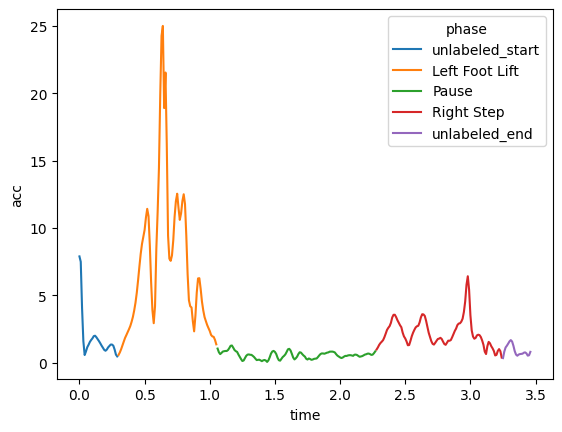

In [56]:
sns.lineplot(df,x='time',y='acc',hue='phase')
plt.show()

## Load new series and warp labels

In [57]:
new_series_file = 'label_studio/isolated_Palin_steps/palin_step_3.json'

with open(new_series_file, "r") as f:
    new_data = json.load(f)

new_time = np.array(new_data[0]['data']['ts']['acc_time'],dtype=float)
new_acc = np.array(new_data[0]['data']['ts']['acc'],dtype=float)

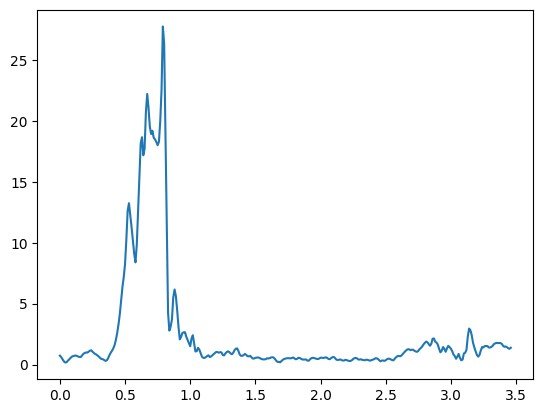

In [58]:
sns.lineplot(x=new_time,y=new_acc)
plt.show()

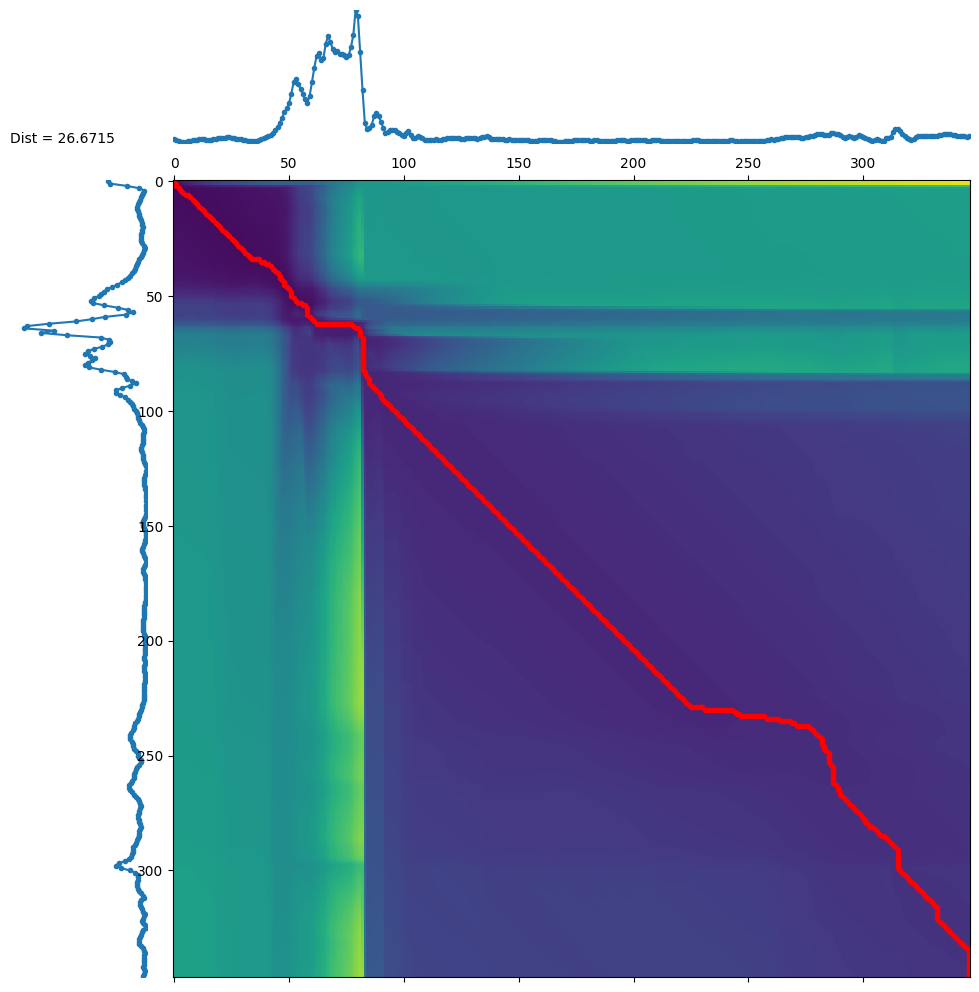

In [60]:
d, paths = dtw.warping_paths_fast(np.array(df.acc), new_acc, penalty=1.5, psi=0)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(np.array(df.acc), new_acc, paths, best_path)
plt.show()

In [63]:
best_path[50:70]

[(44, 48),
 (45, 48),
 (46, 49),
 (47, 50),
 (48, 51),
 (49, 51),
 (50, 51),
 (51, 52),
 (52, 53),
 (53, 54),
 (53, 55),
 (54, 56),
 (54, 57),
 (55, 58),
 (56, 58),
 (57, 58),
 (58, 58),
 (59, 59),
 (60, 60),
 (61, 61)]

In [70]:
new_labels = np.zeros(new_acc.shape,dtype=np.object_)
ref_phase_list = df.phase.to_list()
for mapping in best_path:
    new_labels[mapping[1]] = ref_phase_list[mapping[0]]

In [71]:
new_labels

array(['unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'unlabeled_start', 'unlabeled_start', 'unlabeled_start',
       'Left Foot Lift', 'Left Foot Lift', 'Left Foot Lift',
       'Left Foot Lift', 'Left Foot Lift', 'Left Foot Lift',
       'Left Foot Lift', 'Left Foot Lift', 'Left Foot Lift',
       'Left Foot Lift', 'Left Foot Lift', 'Left Foot Lift',
       'Left Foot Lift', 'Left Foot Lift', 'Left Foot Lift',
       'Left Foot Lift', 'Left Foot Lift', 'Left Foot L

In [72]:
new_df = pd.DataFrame(
    {
        'time':new_time,
        'acc':new_acc,
        'phase':new_labels
    }
)

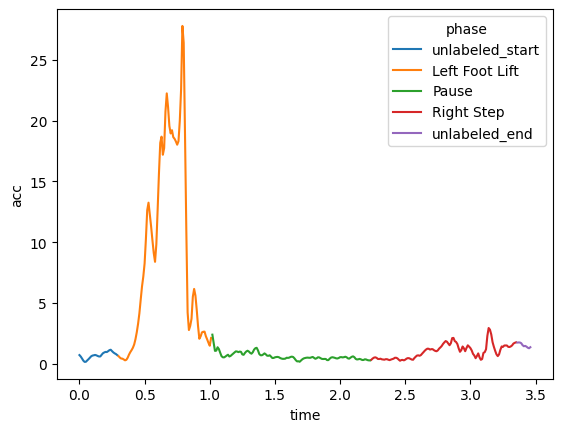

In [73]:
sns.lineplot(new_df,x='time',y='acc',hue='phase')
plt.show()

Compare them:

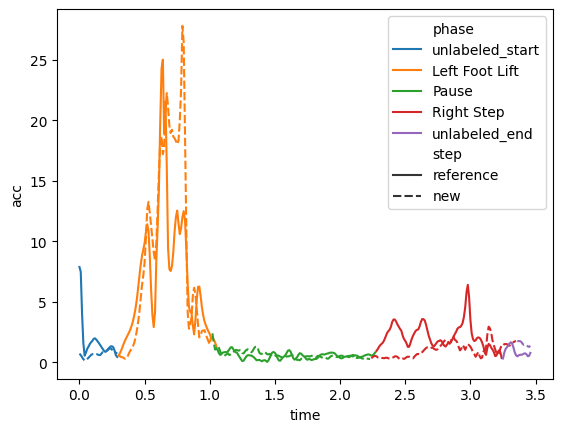

In [81]:
df['step'] = 'reference'
new_df['step'] = 'new'
compare_df = pd.concat([df,new_df],ignore_index=True)

sns.lineplot(compare_df,x='time',y='acc',hue='phase',style='step',dashes=True)
plt.show()